### Linear Regression the Bayesian Way

**Goal:** This is a simple notebook demonstrating three approaches to fitting Bayesian Linear Regression. We use a model, where we assume that the variance $\sigma^2$ of the data generating process is known. For that simple setting it is possible to derive a analytical solution. The notebook consists of the following parts.

* Analytical solution
* Variational Approch ("by hand")
* Variational Approch using the keras layers `tfp.layers.DenseReparameterization` 

**Usage:** Try to understand the provided code.

**Dataset:** Linear Regression with 4 random data points (also used in chapter 7 in the Bayesian the hackers way).

This notebook is acompaning code to the book [https://www.manning.com/books/probabilistic-deep-learning-with-python](https://www.manning.com/books/probabilistic-deep-learning-with-python?a_aid=probabilistic_deep_learning&a_bid=78e55885)

### Status content complete, need a little wording and polishing

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [4]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [5]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 15}) # Large Fonts

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0
TF  Version 2.0.0


# Creation of data

Creation of some data and definition of parameters

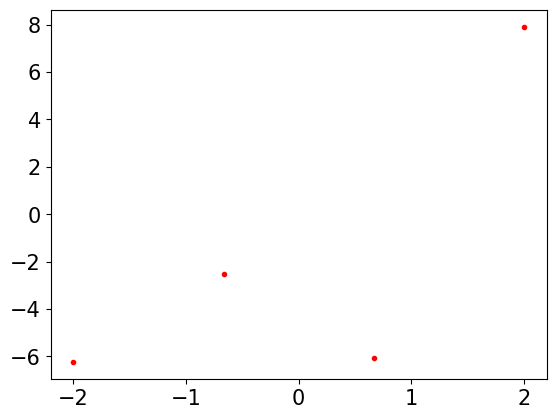

In [33]:
np.random.seed(2)
num = 4
#nbins = 30 #used to create the plots for the book (takes quite some time)
#nbins = 30
#nbins_c=30; 

sigma=3
bmin=-10;bmax=8
amin=-3;amax=8
xmin = -5;xmax = +5;ymin=-40;ymax=40;

#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 

plt.scatter(x,y, marker='.', color='r')
plt.show()

#d = np.transpose(np.vstack((x[:,0],y)))
#np.savetxt('data_blr_{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     

## Linear Regression as baseline
Using a non-Bayesian treatment with fixed weights.

In [36]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml)

Coefficients a_ml:  2.9205102572725816 Coefficients b_ml -1.726712471421449


# Analytical Solution

See also: nb_ch07_02.

For the special case that $\sigma$ is known there exists an analytic solution. For the analytical solution is is further assumed that the prios for a and b are both normally descributed (no correlation) with same spread of the prior distribution $\sigma_0$.

$$
    a \sim N(0,\sigma_0)
$$

$$
    b \sim N(0,\sigma_0)
$$

Without going into details, the analytical solution can be obtained using the following code. If you are interested the analytical details, they are derived in [Bishop Pattern Recognition and Machine Learning.](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf). There is also a blog post describing descriping the solution http://krasserm.github.io/2019/02/23/bayesian-linear-regression/.

In [37]:
def make_design_matrix(x):
    return np.hstack((np.ones((len(x),1)), x))

def posterior(x, y, one_over_var0, var):
    """
        x vector with training x data
        y vector with training y values
        one_over_var0 1/𝜎0^2 the variances of the prior distribution
        var is the assumed to be known variance of data
        @returns mean vector mu and covariance Matrix Sig 
    """
    X = make_design_matrix(x)
    Sig_inv = one_over_var0 * np.eye(X.shape[1]) + X.T.dot(X) / var
    Sig = np.linalg.inv(Sig_inv)
    mu = Sig.dot(X.T).dot(y) / var
    return mu, Sig

def posterior_predictive(x_test, mu, Sig, var):
    """
        x_test the positions, where the posterior is to be evaluated
        mu the mean values of the weight-posterior
        Sig the covariance matrix 
        var is the assumed to be known variance of data 
        Computes mean and variances of the posterior predictive distribution of y
    """
    X_test = make_design_matrix(x_test)
    y = X_test.dot(mu)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = var + np.sum(X_test.dot(Sig) * X_test, axis=1)  
    return y, y_var

m, Sigma = posterior(x, y, 1./1.0**2, sigma**2)
print('Analytical Solution:\n mean (b,a):',m, '\n sigma:\n',Sigma)

mu_b_ana,mu_a_ana = m
sig_b_ana = Sigma[0,0] 
sig_a_ana = Sigma[1,1]

Analytical Solution:
 mean (b,a): [-0.53129615  1.45118522] 
 sigma:
 [[6.92307692e-01 1.71864434e-17]
 [1.71864434e-17 5.03105590e-01]]


# Variational inference by hand

An approximation to Bayes, which is used especially for Neural Networks, is Variational Bayes. We now calculate the variational inference "by hand" i.e. without using Keras layers. 

We model the posterior with 2 independent Gaussians. The four variational parameters are: $\mu_a, \sigma_a$ for the distribution determining the slope $a$, and $\mu_a, \sigma_a$ for the intercept $b$. For all parameters $N(0,1)$ Gaussians are assumed as priors.

$$
KL(p(q|\theta) || P(w)) 
$$


For Gaussians with $N(0,1)$ priors, we can calculate this as (see Kingma Welling 2013 VAE paper in the appendix)
$$
    KL(q(\mu_1|\sigma_1) || N(0,1)) = -\frac{1}{2}  (1 + log(\sigma^2) - \mu^2 - \sigma^2) 
$$

We can check this result by using TFP. 

In [38]:
mu = 2.
s  = 3.
print(tfd.Normal(2, 3).kl_divergence(tfd.Normal(0, 1)))
-(1. + np.log(s**2) - mu**2 - s**2)/2.

tf.Tensor(4.9013877, shape=(), dtype=float32)


4.90138771133189

We use one vector of size 4 to encode the variational parameters. Foreach Gaussian we model $\mu$ and $\sigma = \tt{softplus(\rho)}$. The softplus ensures that, we do not get negative values for $\sigma$. 

We further imply the reparameterization trick (for backpropagation) and write

$$
 q(b) = N(\mu_b, \sigma_b) = \mu_b + \sigma_b \cdot \epsilon \; \; \epsilon \thicksim N(0,1)  
$$

Don't trust this? We can try to write
$N(2,3)=2+3 \cdot N(0,1)$

Normal (2,3) mu =  2.0  sdtdev =  3.0


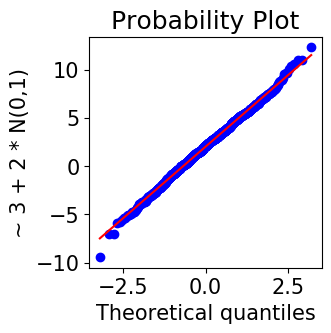

(2.001256, 2.964035)

In [39]:
# Verification with sampling
n23 = tfd.Normal(2,3)
print('Normal (2,3) mu = ',n23.mean().numpy(),' sdtdev = ',n23.stddev().numpy())
fig = plt.figure(figsize=(3,3))
import scipy.stats as stats
n23_rep_sample = 2. + 3. * tfd.Normal(0,1).sample(1000)
stats.probplot(n23_rep_sample, dist="norm", plot=plt) 
plt.ylabel("~ 3 + 2 * N(0,1)")
plt.show()
np.mean(n23_rep_sample), np.std(n23_rep_sample)

In [40]:
# Side note: You cannot calculate and have a distribution. 
# n23_rep = 2. + 3. * tfd.Normal(0,1) 
# But you can use a Bijector to go from one distribution to another 
tfb = tfp.bijectors
base = tfd.Normal(0,1)
bijector = tfp.bijectors.AffineScalar(shift=2, scale=3)
dist = tfd.TransformedDistribution(distribution=base, bijector=bijector)
dist.mean()

<tf.Tensor: id=2312061, shape=(), dtype=float32, numpy=2.0>

In [41]:
## Convenience function to write out weights
class Logger:
    """
        Writes out the weights, gradient, and losses. To be used later in e.g. R. n is the numbver of weights
    """  
    def __init__(self, steps, num_weights = 4):
        self.steps = steps
        self.num_weights = num_weights
        self.X = np.zeros((steps, 12))
        self.header = 'epoch,w0,w1,w2,w3,wg0,wg1,wg2,wg3,loss,loss_kl,loss_mse'
        
    def log(self, step, epoch, w, w_grad, loss, loss_kl, loss_mse):
        n = self.num_weights
        self.X[step,0] = epoch
        self.X[step,1:(n+1)] = w.numpy()
        self.X[step,(n+1):((2*n)+1)] = w_grad.numpy()
        self.X[step,((2*n)+1)] = loss.numpy()
        self.X[step,((2*n)+2)] = loss_kl.numpy()
        self.X[step,((2*n)+3)] = loss_mse.numpy()
        
    def write4r(self, filename):
        np.savetxt(filename, self.X, delimiter=',', header=self.header,comments="",fmt='%.4e');
        
    def getX(self):
        return self.X

#### Listing 8.1 The full code of doing variational inference for the example

In [42]:
epochs=10000
logger = Logger(epochs)
lr = 0.001
optimizer = tf.keras.optimizers.SGD(lr)

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
w_0=(1.,1.,1.,1.)  #A 
w = tf.Variable(w_0)   
e = tfd.Normal(loc=0., scale=1.) #B 
ytensor = y.reshape([len(y),1]) #A
for i in range(epochs):
    with tf.GradientTape() as tape: 
        
        mu_a = w[0] #C
        sigma_a = tf.math.softplus(w[1]) #D
        
        mu_b= w[2]  #E 
        sigma_b= tf.math.softplus(w[3]) #F 
            
        loss_kl = -0.5*(1.0 + tf.math.log(sigma_a**2) - sigma_a**2 - mu_a**2 + #G
                        1.0 + tf.math.log(sigma_b**2) - sigma_b**2 - mu_b**2)
       
        a =  mu_a + sigma_a * e.sample()  #H
        b =  mu_b + sigma_b * e.sample()  #I
        
        y_prob = tfd.Normal(loc=x*a+b, scale=sigma)
        loss_nll = -tf.reduce_sum(y_prob.log_prob(ytensor)) #J
       
        loss = loss_nll + loss_kl
    grads = tape.gradient(loss, w) 
    logger.log(i, i, w, grads, loss, loss_kl, loss_nll)
    w = tf.Variable(w - lr*grads)  # G
    

#A The initial condition of the weight vector w
#B The noise term, needed for the variational trick
#C This controls the center of parameter a 
#D This controls the spread of parameter a
#E This controls the center of b 
#F Control of the spread of b
#G KL-Divergence with Gaussian Priors 
#H Sample a ~ N(mu_a, sigma_a) with reparametrization trick
#I Sample b ~ N(mu_b, sigma_b)
#J Calculation of the NLL
#G Gradient Descent step

    if i % 2000 == 0 or i < 2:
        print(i, " loss ", loss.numpy(), " lr ", lr)
        print('a_mu', w[0].numpy(),'b_mu', w[2].numpy())

0  loss  14.929233  lr  0.001
a_mu 1.0007876 b_mu 0.99811447
1  loss  14.645294  lr  0.001
a_mu 1.0008315 b_mu 0.9958999
2000  loss  16.989773  lr  0.001
a_mu 1.4305325 b_mu -0.44381997
4000  loss  14.318132  lr  0.001
a_mu 1.4604927 b_mu -0.5175722
6000  loss  16.795832  lr  0.001
a_mu 1.430776 b_mu -0.54744184
8000  loss  13.148726  lr  0.001
a_mu 1.4765966 b_mu -0.52346253


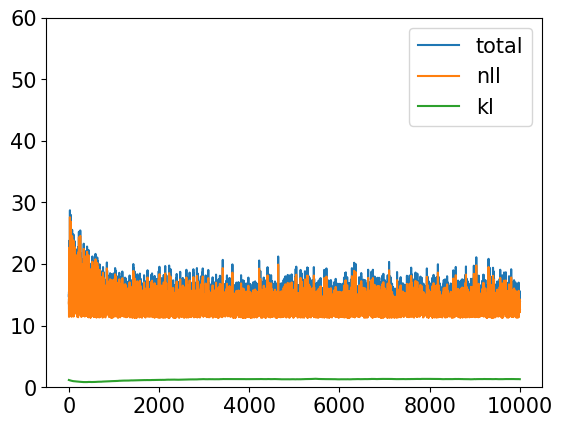

b =  1.6585327   0.70577645  a =  -0.5305455   0.83267325


In [43]:
W = logger.getX()
loss_history = W[:,9]
loss_history_nll = W[:,10]
loss_history_kl = W[:,11]
plt.plot(loss_history)
plt.plot(loss_history_kl)
plt.plot(loss_history_nll)
plt.legend(('total', 'nll', 'kl'))
plt.ylim(0,60)
plt.show()
print('b = ', tf.math.softplus(w[0]).numpy(), ' ', tf.math.softplus(w[1]).numpy(), 
      ' a = ', w[2].numpy(), ' ',  tf.math.softplus(w[3]).numpy())

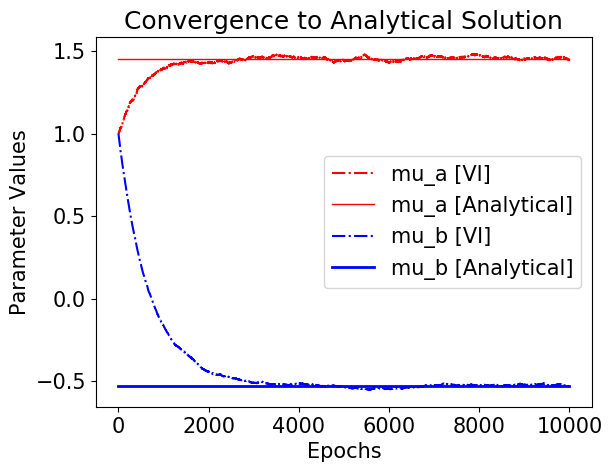

In [44]:
W = logger.getX()
weights = W[:,1:5]
epochs = W.shape[0]
from matplotlib.pyplot import figure

#slope a
plt.plot(weights[:,0],color='r',linestyle='-.')
plt.plot([0, epochs], [mu_a_ana, mu_a_ana], linewidth=1,color='r', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Parameter Values')

plt.plot(weights[:,2],color='b', linestyle='-.')
plt.plot([0, epochs], [mu_b_ana, mu_b_ana], linewidth=2, color='b', linestyle='-')
plt.legend(('mu_a [VI]', 'mu_a [Analytical]', 'mu_b [VI]','mu_b [Analytical]'))

plt.title('Convergence to Analytical Solution')
plt.savefig('ch08_lr.pdf')   # no plt.show() in previous line! 

The log file has been processed using R (make_animation.R) to create the following animation using 

logger.write4r('vi.csv')

In [45]:
from IPython.display import HTML
# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/MC_5Ne3Dj6g" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" /> Now return the the main text to chapter 8.3, where variational inference with TFP is described.

# Introduction to TFP

Now let's reproduce the above result with TFP. But bevor we show how simple it is to create a network.

#### Listing 8.2 Setting up a VI network with three layers in TFP

In [46]:
model = tf.keras.Sequential([
  tfp.layers.DenseReparameterization(1, input_shape=(None,1)),
  tfp.layers.DenseReparameterization(2),
  tfp.layers.DenseReparameterization(3)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_reparameterization_4 ( (None, None, 1)           3         
_________________________________________________________________
dense_reparameterization_5 ( (None, None, 2)           6         
_________________________________________________________________
dense_reparameterization_6 ( (None, None, 3)           15        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


### Comparing with TFP

Now we compare again TFP. Note that we also have to include a distribution on the bias and weight.

#### Listing 8.3 The code for  our simple network from figure 8.bnn4

In [47]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#123456789012345678901234567890123456789012345678901234
def NLL(y, distr):#C
    return -distr.log_prob(y) 
    
def my_dist(mu): #C
    return tfd.Normal(loc=mu[:,0:1], scale=sigma)

divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0) #B


model = tf.keras.Sequential([
    tfp.layers.DenseReparameterization(1,
       kernel_divergence_fn=divergence_fn,
       bias_divergence_fn=divergence_fn, #A
       bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,#A
       bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn()#A
                                       ),
    tfp.layers.DistributionLambda(my_dist)
])


sgd = tf.keras.optimizers.SGD(lr=.005)
model.compile(loss=NLL, optimizer=sgd)

# A note that TFP usually does not assume distributions on the bias, we overwrite this here. 
# B Rescaling KL-divergence term. Kind of Bug fix for TFP
# C The usual NLL loss for a Gaussian Distribution with fixed variance 

Text(0, 0.5, 'Total loss')

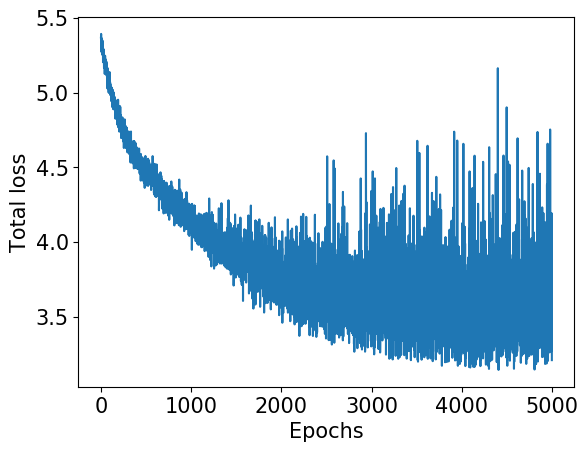

In [48]:
hist = model.fit(x, y, epochs=5000, batch_size=num, verbose=False)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Total loss')

## Comparison of the results

In [49]:
import pandas as pd
def sp(x):
    return np.log(1 + np.exp(x))**2

wtfp = model.get_weights()
ww = w.numpy()
pd.DataFrame({
    'Analytical ':[mu_a_ana, sig_a_ana,  mu_b_ana, sig_b_ana], 
    'TFP ':[wtfp[0][0,0], sp(wtfp[1][[0]])[0,0],wtfp[2][0], sp(wtfp[3][[0]])[0]], 
    'VI Manual ': [ww[0], sp(ww[1]), ww[2], sp(ww[3])], 
    'MaxLike':[a_ml[0], '-', b_ml, '-'] 
    }, 
    index=['a_loc','a_sig','b_loc','b_sig']
)

,Analytical,TFP,VI Manual,MaxLike
a_loc,1.451185,1.468727,1.447295,2.92051
a_sig,0.503106,0.475734,0.498120,-
b_loc,-0.531296,-0.532938,-0.530545,-1.72671
b_sig,0.692308,0.653613,0.693345,-


<img src="https://as1.ftcdn.net/jpg/01/33/91/60/500_F_133916095_PS4juqjP6hNZvIHHT43ehNqlpRyqGDTV.jpg" width="300" align="left" />